In [27]:
!pip install ucimlrepo

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


## Fetching raw data

In [29]:
print("Fetching 'Adult' dataset ")
adult = fetch_ucirepo(id=2)

X = adult.data.features.copy()
y = adult.data.targets.copy()

print("Data Loaded!")
print("Feature Shape:", X.shape)
print("Target Shape:", y.shape)


Fetching 'Adult' dataset 
Data Loaded!
Feature Shape: (48842, 14)
Target Shape: (48842, 1)


In [30]:
# Converting y DataFrame → Series
y = y.iloc[:, 0]

# CLEANING STRING COLUMNS
def clean_strings(df):
    df = df.copy()
    for c in df.select_dtypes(include=["object"]).columns:
        df.loc[:, c] = df[c].astype(str).str.strip().replace("?", np.nan)
    return df

X = clean_strings(X)
y = y.astype(str).str.strip()

# CONVERTING TARGET TO 0/1
y = y.replace({">50K": 1, "<=50K": 0, ">50K.": 1, "<=50K.": 0}).astype(int)

df = pd.concat([X, y.rename("income")], axis=1)

# CONVERTING NUMERIC COLUMNS
numeric_cols = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# IMPUTING MISSING VALUES
for col in df.columns:
    if df[col].isna().sum() > 0:
        if df[col].dtype.kind in 'biufc':
            df.loc[:, col] = df[col].fillna(df[col].median())
        else:  # categorical
            df.loc[:, col] = df[col].fillna(df[col].mode()[0])
df = df.iloc[:20000, :]
# SAVING PROCESSED DATA
df.to_csv("adult_processed.csv", index=False)
print("Processed dataset saved as 'adult_processed.csv'")

/tmp/ipython-input-3928710291.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({">50K": 1, "<=50K": 0, ">50K.": 1, "<=50K.": 0}).astype(int)


Processed dataset saved as 'adult_processed.csv'


# Loading and showing preprocess data

In [31]:
df = pd.read_csv("adult_processed.csv")
print(df.head())

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country  income  
0          2174             0              40  United-States       0  
1             0             0           

# EDA and Visualisation

In [32]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             20000 non-null  int64 
 1   workclass       20000 non-null  object
 2   fnlwgt          20000 non-null  int64 
 3   education       20000 non-null  object
 4   education-num   20000 non-null  int64 
 5   marital-status  20000 non-null  object
 6   occupation      20000 non-null  object
 7   relationship    20000 non-null  object
 8   race            20000 non-null  object
 9   sex             20000 non-null  object
 10  capital-gain    20000 non-null  int64 
 11  capital-loss    20000 non-null  int64 
 12  hours-per-week  20000 non-null  int64 
 13  native-country  20000 non-null  object
 14  income          20000 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 2.3+ MB
None


In [33]:
print(df.describe())

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  20000.000000  2.000000e+04   20000.000000  20000.000000  20000.000000   
mean      38.595450  1.898208e+05      10.084850   1068.711000     87.950900   
std       13.662299  1.053460e+05       2.554443   7387.816572    402.985767   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.186272e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783335e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.372775e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week        income  
count     20000.00000  20000.000000  
mean         40.39670      0.238050  
std          12.27874      0.425901  
min           1.00000      0.000000  
25%          40.00000      0.000000  
50%          40.00000      0.000000  
75%          

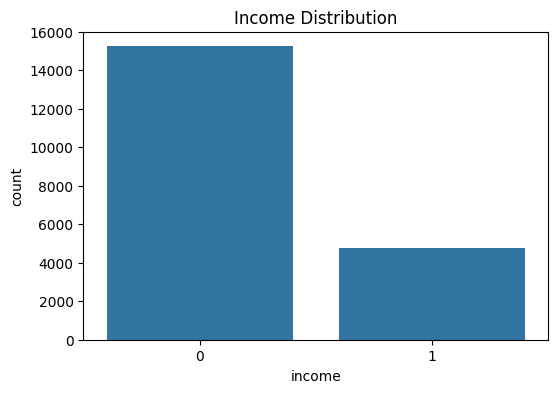

In [34]:
# Income distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="income")
plt.title("Income Distribution")
plt.show()

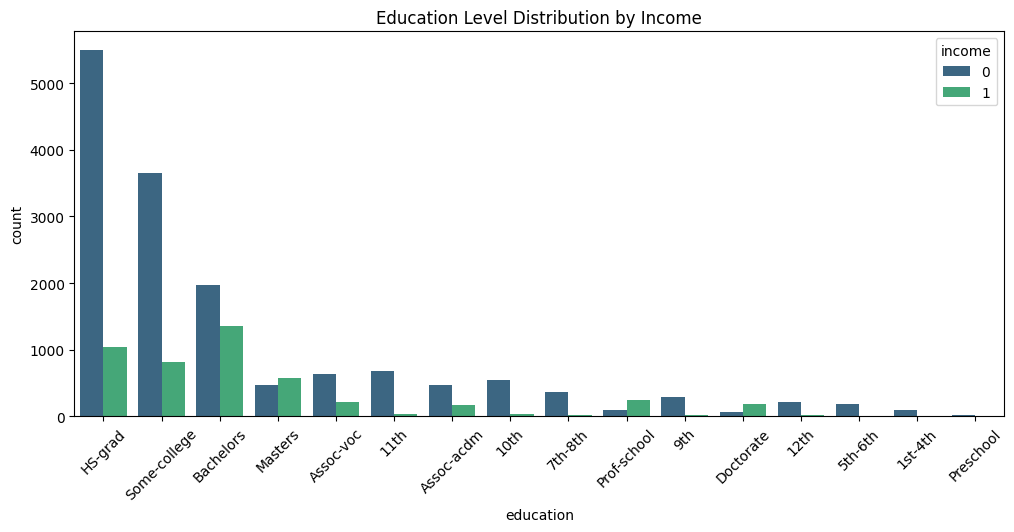

In [51]:
# Distribution of education levels by income
plt.figure(figsize=(12,5))
sns.countplot(data=df, x="education", hue="income", order=df["education"].value_counts().index, palette="viridis")
plt.title("Education Level Distribution by Income")
plt.xticks(rotation=45)
plt.show()

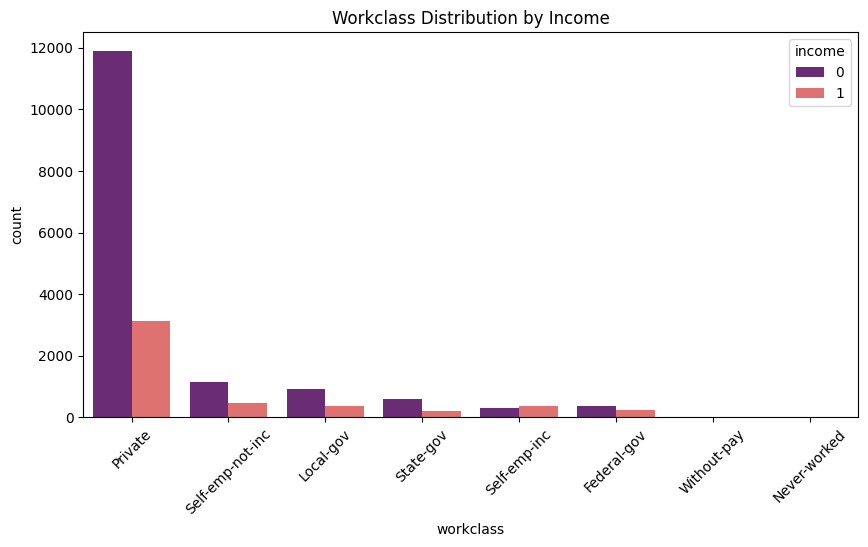

In [52]:
# Workclass distribution by income
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="workclass", hue="income", order=df["workclass"].value_counts().index, palette="magma")
plt.title("Workclass Distribution by Income")
plt.xticks(rotation=45)
plt.show()

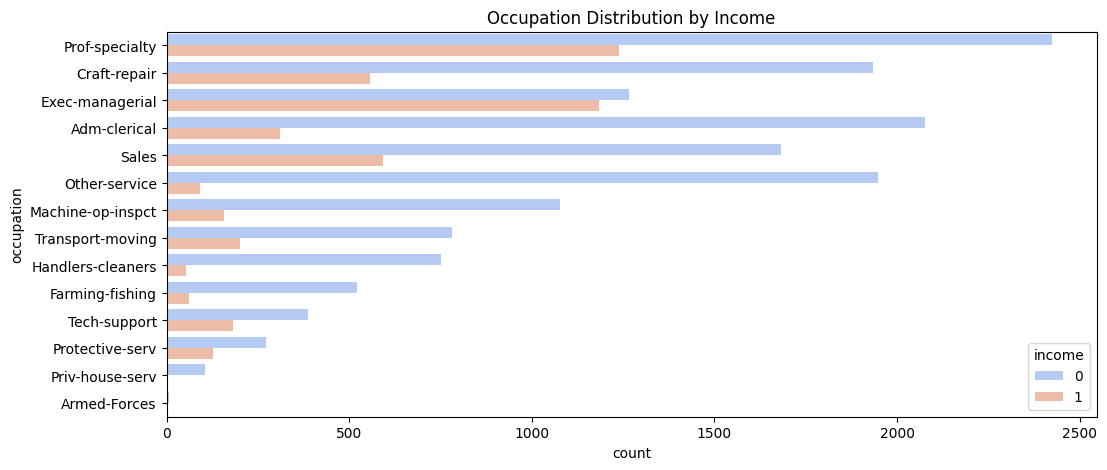

In [53]:
# Occupation distribution by income
plt.figure(figsize=(12,5))
sns.countplot(data=df, y="occupation", hue="income", order=df["occupation"].value_counts().index, palette="coolwarm")
plt.title("Occupation Distribution by Income")
plt.show()

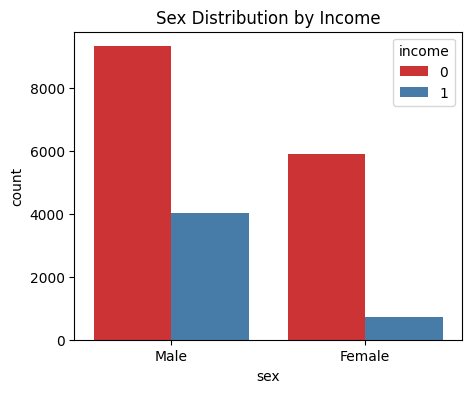

In [54]:
#  Sex and income
plt.figure(figsize=(5,4))
sns.countplot(data=df, x="sex", hue="income", palette="Set1")
plt.title("Sex Distribution by Income")
plt.show()

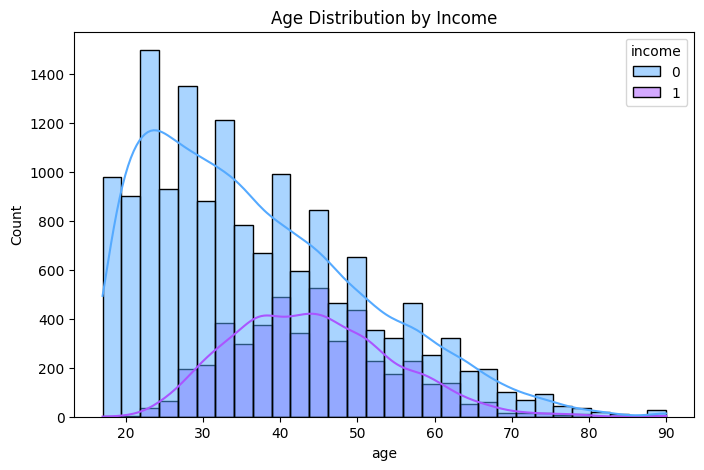

In [56]:
#  Age distribution by income
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="age", hue="income", bins=30, kde=True, palette="cool")
plt.title("Age Distribution by Income")
plt.show()

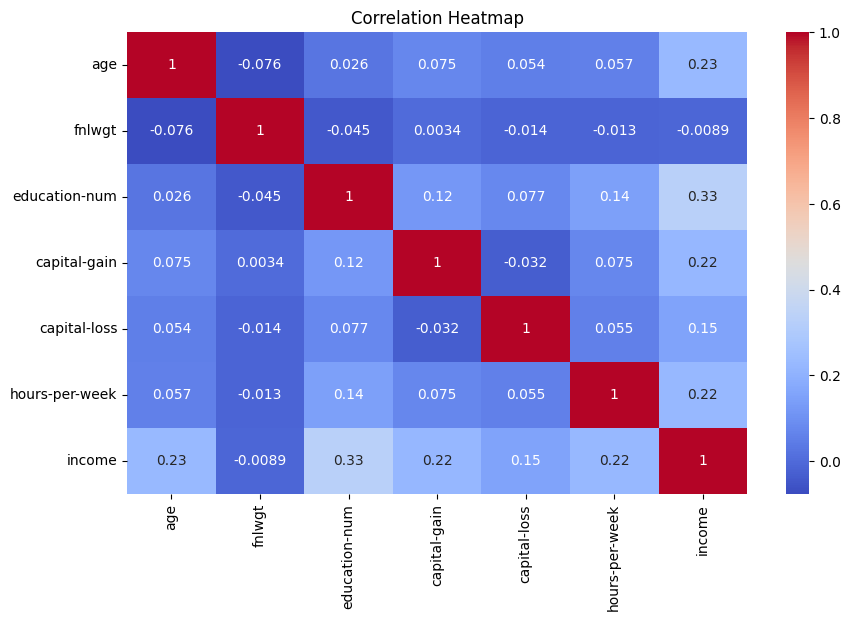

In [37]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols + ["income"]].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


# Feature selection and train-test spliting

In [38]:
X = df.drop("income", axis=1)
y = df["income"]

# one hot encode categoricals
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=True)

feature_names = X_enc.columns

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.25, random_state=42, stratify=y
)


In [39]:
# Scaling numeric columns
scaler = StandardScaler()
num_cols_in_X = [c for c in numeric_cols if c in X_enc.columns]

X_train[num_cols_in_X] = scaler.fit_transform(X_train[num_cols_in_X])
X_test[num_cols_in_X] = scaler.transform(X_test[num_cols_in_X])

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (15000, 97)
Test shape: (5000, 97)


# Machine learning model

## Helper function for Confusion matrix and roc curve

In [40]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_roc_curve(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

    return roc_auc


# Training Logistic regression

In [41]:
print("Training Logistic Regression")
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_lr))


Training Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      3810
           1       0.73      0.58      0.64      1190

    accuracy                           0.85      5000
   macro avg       0.80      0.76      0.77      5000
weighted avg       0.84      0.85      0.84      5000



## Confusion matrix for Logistic regression

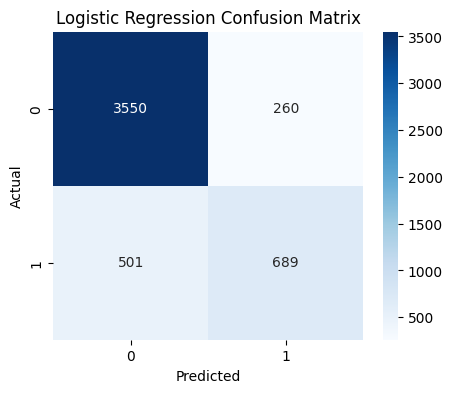

In [42]:
plot_conf_matrix(y_test, y_pred_lr, "Logistic Regression Confusion Matrix")


## ROC-AUC for Logistic regression

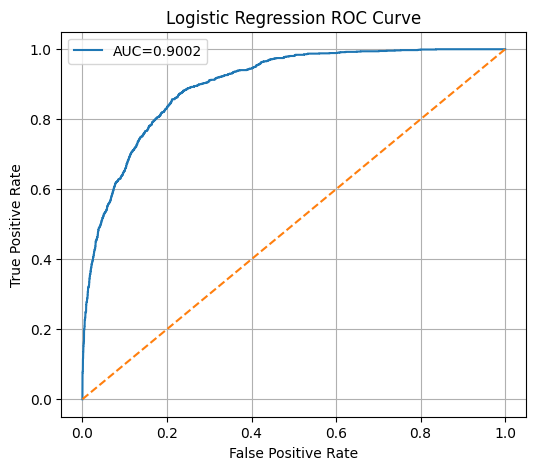

In [43]:
auc_lr = plot_roc_curve(y_test, y_prob_lr, "Logistic Regression ROC Curve")

acc_lr = accuracy_score(y_test, y_pred_lr)

## Training SVM (Support vector machine)

In [44]:
print("Training SVM ")
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
y_prob_svm = svm.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_svm))


Training SVM 
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3810
           1       0.77      0.57      0.66      1190

    accuracy                           0.86      5000
   macro avg       0.82      0.76      0.78      5000
weighted avg       0.85      0.86      0.85      5000



## Confusion matrix for SVM

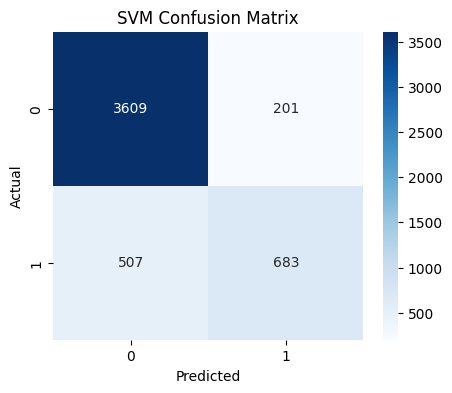

In [45]:
plot_conf_matrix(y_test, y_pred_svm, "SVM Confusion Matrix")


## ROC-AUC for SVM

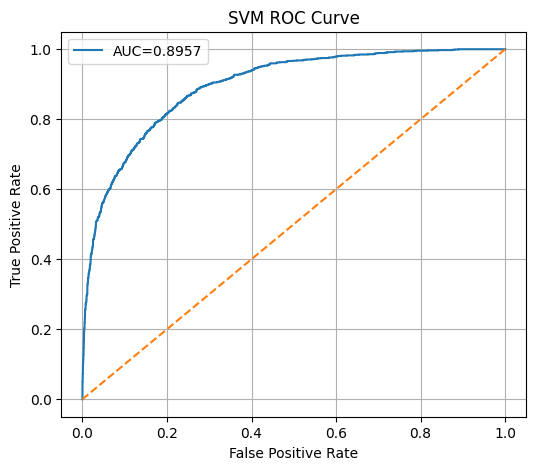

In [46]:
auc_svm = plot_roc_curve(y_test, y_prob_svm, "SVM ROC Curve")

acc_svm = accuracy_score(y_test, y_pred_svm)

# Training Decision tree

In [47]:
print("Training Decision Tree")
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_dt))


Training Decision Tree
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      3810
           1       0.59      0.61      0.60      1190

    accuracy                           0.81      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.81      0.81      0.81      5000



## Confusion matrix for Decision tree

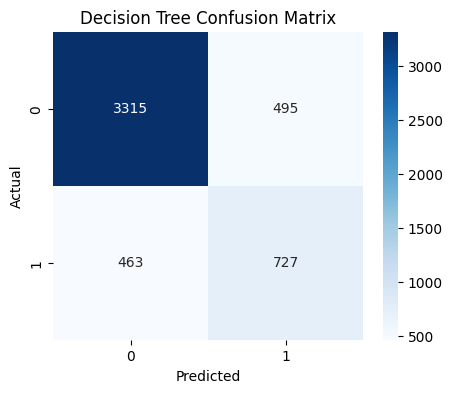

In [48]:
plot_conf_matrix(y_test, y_pred_dt, "Decision Tree Confusion Matrix")


## ROC-AUC for Decision tree

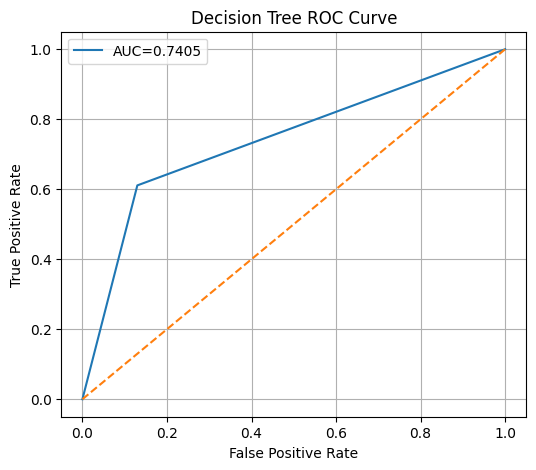

In [49]:
auc_dt = plot_roc_curve(y_test, y_prob_dt, "Decision Tree ROC Curve")

acc_dt = accuracy_score(y_test, y_pred_dt)

# Model comparison

                 Model  Accuracy       AUC
0  Logistic Regression    0.8478  0.900187
1                  SVM    0.8584  0.895690
2        Decision Tree    0.8084  0.740502


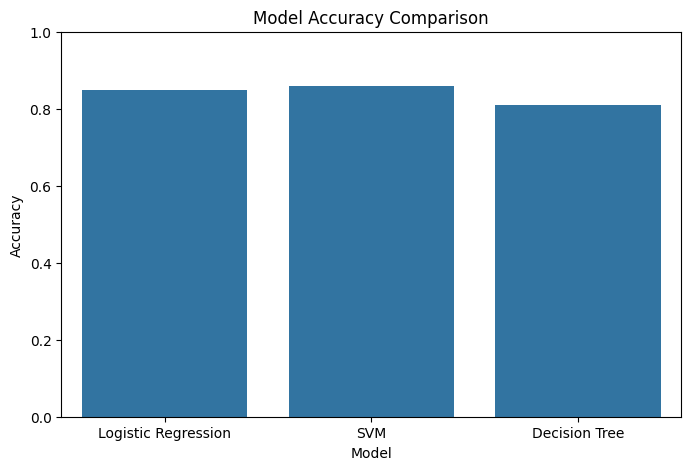

In [50]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Decision Tree"],
    "Accuracy": [acc_lr, acc_svm, acc_dt],
    "AUC": [auc_lr, auc_svm, auc_dt]
})

print(results)

plt.figure(figsize=(8,5))
sns.barplot(data=results, x="Model", y="Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()
